In [1]:
import numpy as np
import pygam
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import itertools
import scipy as sp
import scipy.cluster.hierarchy
from scipy.cluster.hierarchy import fcluster
import pandas as pd
import seaborn as sb
plt.style.use('default')

import sys
sys.path.append("../../scripts")
import visutil

DATA_DIR = "data/"
FIG_DIR = "./"

In [293]:
try:
    my_purple = matplotlib.colors.LinearSegmentedColormap.from_list("MyPurple", ['purple', 'purple', ])
    matplotlib.colormaps.register(cmap = my_purple)
    my_red = matplotlib.colors.LinearSegmentedColormap.from_list("MyRed", ['red', 'red', ])
    matplotlib.colormaps.register(cmap = my_red)
    my_grey = matplotlib.colors.LinearSegmentedColormap.from_list("MyGrey", ['#595959', '#595959', ])
    matplotlib.colormaps.register(cmap = my_grey)
except:
    pass

In [314]:
adata = ad.AnnData(np.load(DATA_DIR+"X.npy"))
adata.obs["dpt"] = np.load(DATA_DIR+"dpt.npy")
# adata.var["gene"] = np.load(DATA_DIR+"genes.npy")
adata.var["gene"] = pd.read_csv('data/genes.csv').iloc[:, 0].to_numpy()
adata.var["gene"] = adata.var["gene"].str.capitalize()
adata.obsm["X_pca"] = np.load(DATA_DIR + "X_pca.npy")
adata.obsm["X_umap"] = np.load(DATA_DIR + "X_umap.npy")
# gene filter
adata.obsm["C"] = np.load(DATA_DIR+"C.npy")
# load locaTE outputs
G = np.load("G_locate.npy")
G = np.swapaxes(G.reshape(-1, adata.shape[1], adata.shape[1]), 1, 2).reshape(-1, adata.shape[1]**2) # fix Julia orientation
U = np.load("U.npy").astype(np.float64)
V = np.load("V.npy").astype(np.float64)
V = np.swapaxes(V.reshape(adata.shape[1], adata.shape[1], -1), 0, 1).reshape(adata.shape[1]**2, -1) # fix Julia orientation

/tmp/ipykernel_113917/4241378371.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  perm = np.argsort([adata.obs.dpt[np.argmax(x / sum(x))] for x in U_gam.T])


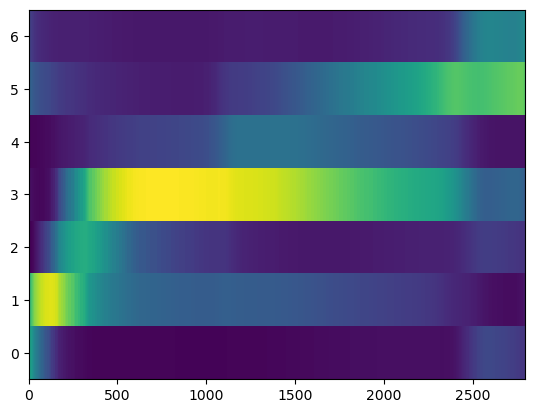

In [316]:
coeff_gam = [pygam.LinearGAM(pygam.s(0)).fit(adata.obs.dpt, u) for u in U.T]
U_gam = np.vstack([g.predict(adata.obs.dpt) for g in coeff_gam]).T
perm = np.argsort([adata.obs.dpt[np.argmax(x / sum(x))] for x in U_gam.T])
U = U[:, perm]
U_gam = U_gam[:, perm]
V = V[:, perm]
plt.imshow(U_gam[np.argsort(adata.obs.dpt), :].T, interpolation = "none", origin = "lower", vmin = 0)
plt.axis("auto")
plt.savefig(FIG_DIR + "NMF_module_activities.pdf")
del perm

/data/gpfs/projects/punim0638/stephenz/miniconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(455.5555555555555, 0.5, 'Regulatory module')

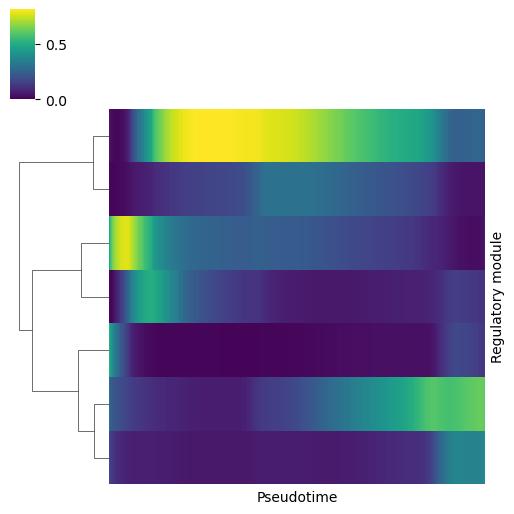

In [296]:
cg = sb.clustermap(U_gam[np.argsort(adata.obs.dpt), :].T, row_cluster = True, col_cluster = False, metric = "correlation", xticklabels = False, yticklabels = False, figsize = (5, 5), cmap = "viridis", vmin = 0)
cg.ax_heatmap.set_xlabel("Pseudotime")
cg.ax_heatmap.set_ylabel("Regulatory module")

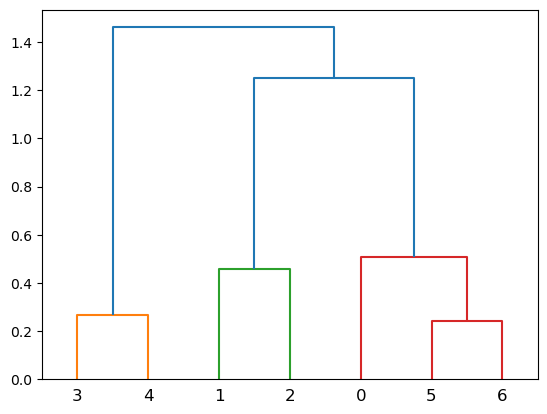

In [297]:
Z = cg.dendrogram_row.calculated_linkage
scipy.cluster.hierarchy.dendrogram(Z);

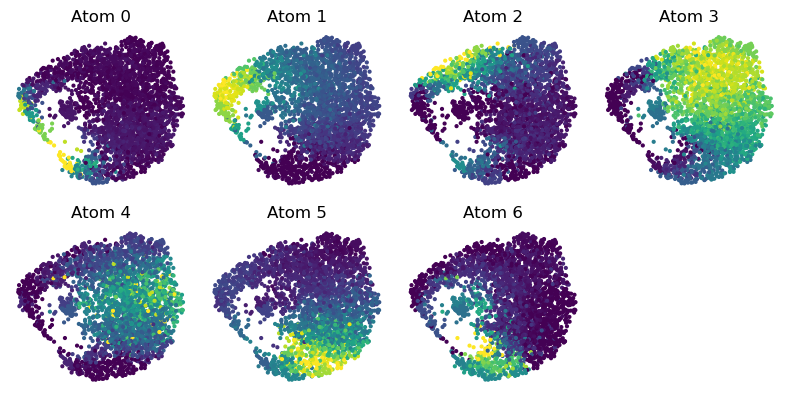

In [298]:
plt.figure(figsize = (8, 8))
for i in range(U.shape[1]):
    plt.subplot(4, 4, i+1)
    plt.scatter(adata.obsm["X_umap"][:, 0], adata.obsm["X_umap"][:, 1], c = U[:, i], s = 4, vmax = np.quantile(U[:, i], 0.99))
    plt.title("Atom {}".format(i))
    plt.axis("off")
plt.tight_layout()

/tmp/ipykernel_113917/84533302.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colordict = {i : matplotlib.cm.get_cmap('tab10')(i-1) for i in range(1, 3+1)}
/data/gpfs/projects/punim0638/stephenz/miniconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


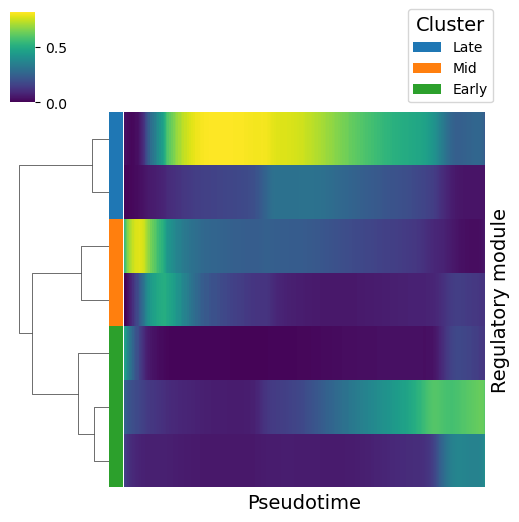

In [299]:
clusterids = fcluster(Z, 3, criterion = 'maxclust')
colordict = {i : matplotlib.cm.get_cmap('tab10')(i-1) for i in range(1, 3+1)}
clusterdict = {3 : "Early", 1 : "Late", 2 : "Mid"}
colors = [colordict[i] for i in clusterids]

from matplotlib.patches import Patch
cg = sb.clustermap(U_gam[np.argsort(adata.obs.dpt), :].T, row_cluster = True, col_cluster = False, metric = "correlation", xticklabels = False, yticklabels = False, figsize = (5, 5), cmap = "viridis", row_colors = colors, rasterized = True, vmin = 0)
cg.ax_heatmap.set_xlabel("Pseudotime", fontsize = 14)
cg.ax_heatmap.set_ylabel("Regulatory module", fontsize = 14)

idxs = [1, 2, 3]
handles = [Patch(facecolor=colordict[i]) for i in idxs]
plt.legend(handles, [clusterdict[i] for i in idxs], title='Cluster',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right', title_fontsize = 14)

In [300]:
import ot 
import itertools
from tqdm import tqdm
import pandas as pd

C = np.zeros((U.shape[1], U.shape[1]))
for (i, j) in tqdm(itertools.product(range(U.shape[1]), range(U.shape[1]))):
    if i > j:
        C[i, j] = ot.emd2(U[:, i] / U[:, i].sum(), U[:, j] / U[:, j].sum(), adata.obsm["C"])
        C[j, i] = C[i, j]
C /= C.mean()

0it [00:00, ?it/s]/data/gpfs/projects/punim0638/stephenz/miniconda3/lib/python3.10/site-packages/ot/lp/__init__.py:571: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
49it [00:32,  1.50it/s]


/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/cellcycle_metabolic/../../scripts/visutil.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nx.draw_networkx_labels(g, pos, labels = {x : gene_names[x] for (c, x) in zip(centrality, nodes)}, font_size = 14);


Text(0.5, 1.0, 'PIDC static network')

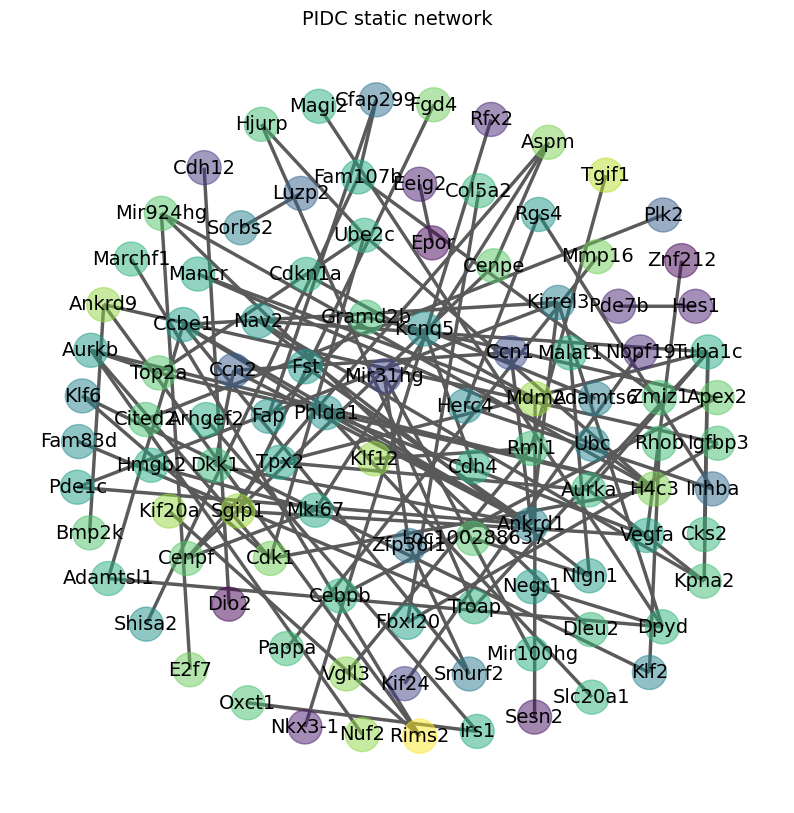

In [301]:
# for PIDC
pd.DataFrame(np.array(adata.X), columns = adata.var.gene).T.to_csv("expr.csv")
A_pidc = np.load("A_pidc.npy");

g = nx.Graph(A_pidc.reshape(adata.shape[1], adata.shape[1]))
nx.set_node_attributes(g, nx.eigenvector_centrality(g, weight = "weight", max_iter = 2_500), "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
plt.figure(figsize = (10, 10))
visutil.draw(g, adata.var.gene, thresh = 0.995, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"}, layout_args = "-Gstart=0")
plt.axis("off")
plt.title("PIDC static network", fontsize = 14)

/data/gpfs/projects/punim0638/stephenz/miniconda3/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


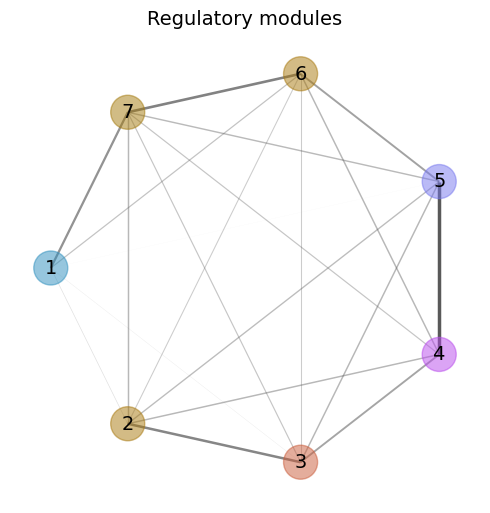

In [302]:
import sklearn as sk
import cmocean
K = np.exp(-C / (np.median(C, axis = -1).reshape(-1, 1)))
K /= K.mean()
# t = np.array([visutil.approx_hitting_time(K / K.sum(-1).reshape(-1, 1), 0, j) for j in range(K.shape[0])])
t = [(U[:, i] * adata.obs["dpt"]).sum() / U[:, i].sum() for i in range(U.shape[1])]
g = nx.Graph(K)
nx.set_node_attributes(g, {i : t[i] for i in range(len(t))}, "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
pos = nx.shell_layout(g)
# discard self loops
g.remove_edges_from(nx.selfloop_edges(g))
plt.figure(figsize = (5, 5))
visutil.draw(g, 
             gene_names = [str(i+1) for i in range(K.shape[0])], 
             thresh = 0.0, pos = pos, 
             kwargs_nodes = {"cmap" : cmocean.cm.phase, "alpha" : [0.5 for i in range(K.shape[0])], }, 
             kwargs_edges = {})
plt.tight_layout()
plt.axis("off")
plt.title("Regulatory modules", fontsize = 14)
plt.savefig("NMF_modules.pdf")

In [303]:
stage = np.array([clusterdict[i] for i in clusterids])
g_all = []
for s in ["Early", "Mid", "Late"]:
    A = np.dot(np.mean(U * (stage == s), 0), V.T)
    g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
    g_all += [g, ]
thresh = 0.999
g_agg, nodes, pos = visutil.get_union_graph(g_all, adata.var.index, thresh, layout_args = "-Gstart=1")

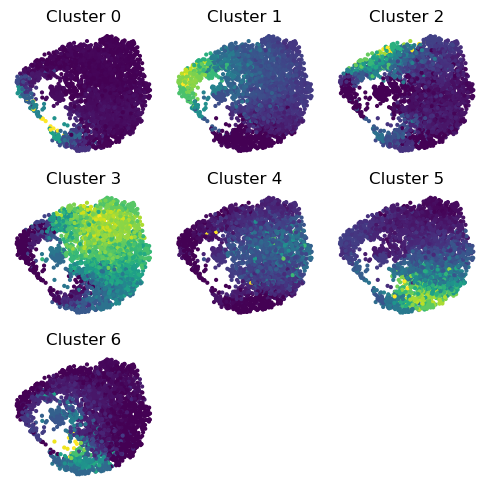

In [306]:
plt.figure(figsize = (5, 5))
for i in range(U.shape[1]):
    plt.subplot(3, 3, i+1)
    plt.scatter(adata.obsm["X_umap"][:, 0], adata.obsm["X_umap"][:, 1], c = U[:, i], s = 4)
    plt.title("Cluster {}".format(i))
    plt.axis("off")
plt.tight_layout()

/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/cellcycle_metabolic/../../scripts/visutil.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nx.draw_networkx_labels(g, pos, labels = {x : gene_names[x] for (c, x) in zip(centrality, nodes)}, font_size = 14);
/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/cellcycle_metabolic/../../scripts/visutil.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nx.draw_networkx_labels(g, pos, labels = {x : gene_names[x] for (c, x) in zip(centrality, nodes)}, font_size = 14);
/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/cellcycle_metabolic

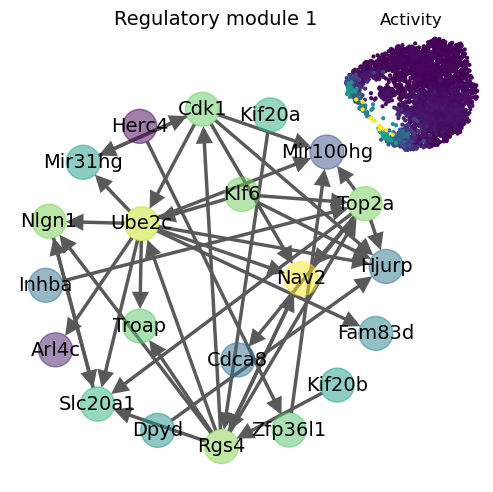

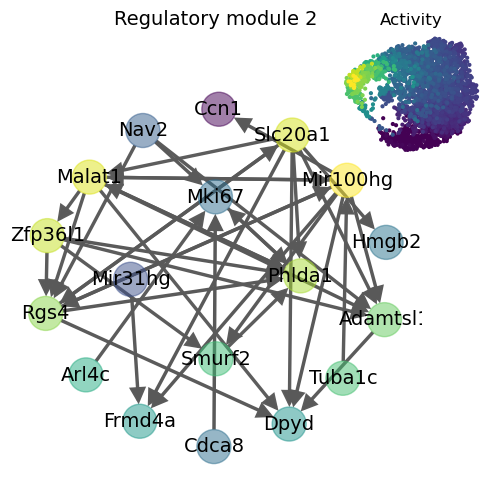

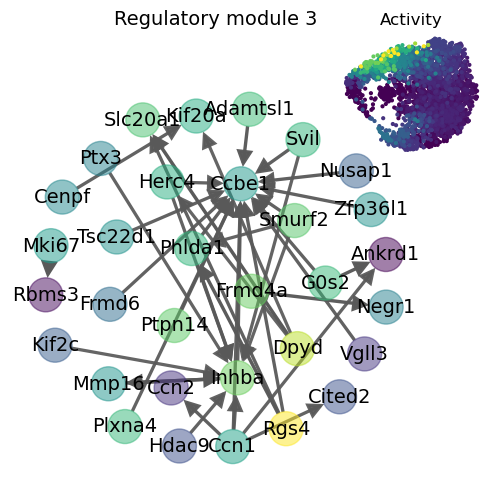

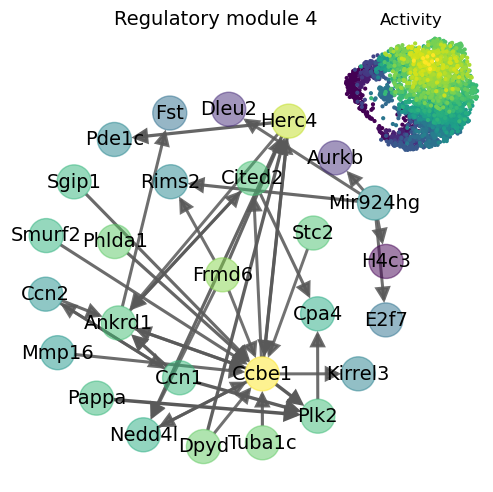

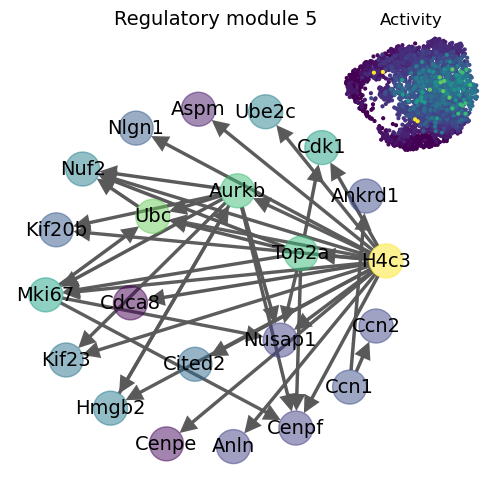

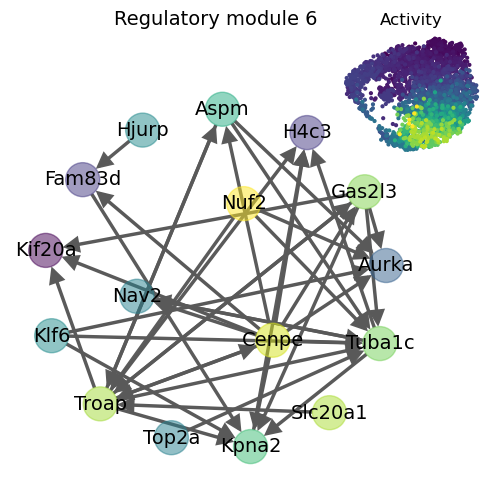

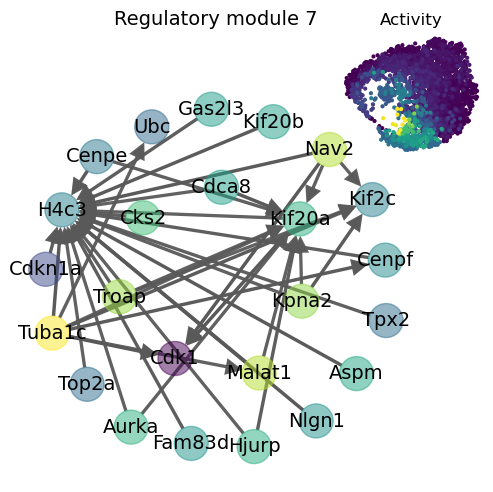

In [307]:
for i in range(V.shape[1]):
    plt.figure(figsize = (5, 5))
    A = V[:, i]
    g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
    nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
    nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 1_000), "centrality")
    visutil.draw(g, adata.var['gene'], thresh = thresh, layout_args = "-Gstart=1")
    # visutil.draw(g, adata.var['gene'], node_list = nodes, pos = pos, thresh = thresh)
    plt.gca().axis("off")
    ax = plt.gca()
    axin = ax.inset_axes([0.8, 0.8, 0.35, 0.3])
    axin.axis("off")
    p = U[:, i]
    axin.scatter(adata.obsm["X_umap"][np.argsort(p), 0], adata.obsm["X_umap"][np.argsort(p), 1], c = np.sort(p), s = 4)
    axin.set_title("Activity")
    plt.title(f"Regulatory module {i+1}", fontsize = 14)
    plt.tight_layout()
    plt.savefig(f"cellcycle_nmf_network_{i+1}.pdf")

In [317]:
# top-k out edges
def outedge_counts(A, cutoff = 1_000):
    cutoff = np.sort(A.flatten())[::-1][cutoff]
    A[A <= cutoff] = 0
    return np.sum(A > 0, -1)

def outedge_eigen_centrality(A):
    g = nx.DiGraph(A)
    nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 1_000), "centrality")
    nodes, centrality = zip(*nx.get_node_attributes(g,'centrality').items())
    return centrality

for s in ["Early", "Mid", "Late"]:
    A = np.dot(np.mean(U * (stage == s), 0), V.T)
    centrality = outedge_eigen_centrality(A.reshape(adata.shape[1], adata.shape[1]))
    pd.DataFrame({"gene" : adata.var.gene[np.argsort(centrality)[::-1][0:25]]}).to_csv("genelist_nmf_%s.csv" % s, header = True, index = False)

/tmp/ipykernel_113917/977330379.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pd.DataFrame({"gene" : adata.var.gene[np.argsort(centrality)[::-1][0:25]]}).to_csv("genelist_nmf_%s.csv" % s, header = True, index = False)


In [319]:
for i in range(V.shape[1]):
    A = V[:, i]
    centrality = outedge_eigen_centrality(A.reshape(adata.shape[1], adata.shape[1]))
    pd.DataFrame({"gene" : adata.var.gene[np.argsort(centrality)[::-1][0:25]]}).to_csv(f"genelist_nmf_{i}.csv", header = True, index = False)

/tmp/ipykernel_113917/1937526459.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pd.DataFrame({"gene" : adata.var.gene[np.argsort(centrality)[::-1][0:25]]}).to_csv(f"genelist_nmf_{i}.csv", header = True, index = False)


/tmp/ipykernel_113917/1837176160.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xticks(range(len(idx)), adata.var.gene[idx], rotation = 60);


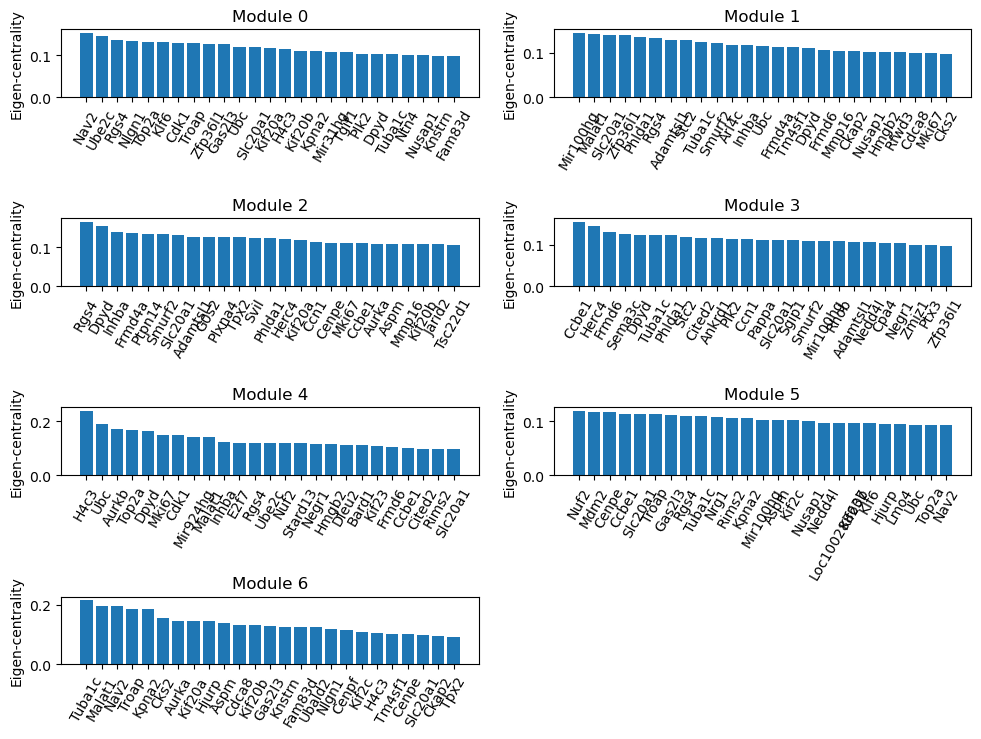

In [334]:
plt.figure(figsize = (10, 7.5))
for i in range(V.shape[1]):
    A = V[:, i]
    centrality = np.array(outedge_eigen_centrality(A.reshape(adata.shape[1], adata.shape[1])))
    idx = np.argsort(centrality)[::-1][0:25]
    plt.subplot(4, 2, i+1)
    plt.bar(range(len(idx)), centrality[idx])
    plt.xticks(range(len(idx)), adata.var.gene[idx], rotation = 60);
    plt.title(f"Module {i}")
    plt.ylabel("Eigen-centrality")
plt.tight_layout()
plt.savefig(FIG_DIR + "cellcycle_nmf_stage_centrality.pdf")

In [310]:
# write for TENET
pd.DataFrame(adata.X, columns = adata.var.gene).to_csv("comparisons/tenet/X.csv")
pd.DataFrame(adata.obs.dpt).to_csv("comparisons/tenet/dpt.csv", index = False, header = False)
pd.DataFrame(np.ones_like(adata.obs.dpt, dtype = np.int64)).to_csv("comparisons/tenet/cellmask.csv", index = False, header = False)

/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/cellcycle_metabolic/../../scripts/visutil.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nx.draw_networkx_labels(g, pos, labels = {x : gene_names[x] for (c, x) in zip(centrality, nodes)}, font_size = 14);


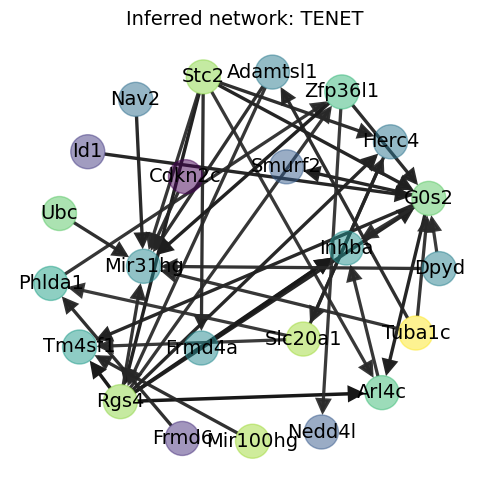

In [311]:
A_tenet = pd.read_csv("comparisons/tenet/A_tenet_3.txt", sep = "\t", index_col = 0)
g = nx.DiGraph(A_tenet.to_numpy())
nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 1_000), "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
fig = plt.figure(figsize = (5, 5))
visutil.draw(g, adata.var.gene, thresh = 0.999, cmap_dict = {0 : "Greys", 1 : "MyRed", -1 : "MyPurple"}, layout_args = "-Gstart=2")
plt.axis("off")
plt.title("Inferred network: TENET", fontsize = 14)
plt.tight_layout()
plt.savefig(FIG_DIR + "cellcycle_tenet.pdf")

/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/cellcycle_metabolic/../../scripts/visutil.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nx.draw_networkx_labels(g, pos, labels = {x : gene_names[x] for (c, x) in zip(centrality, nodes)}, font_size = 14);


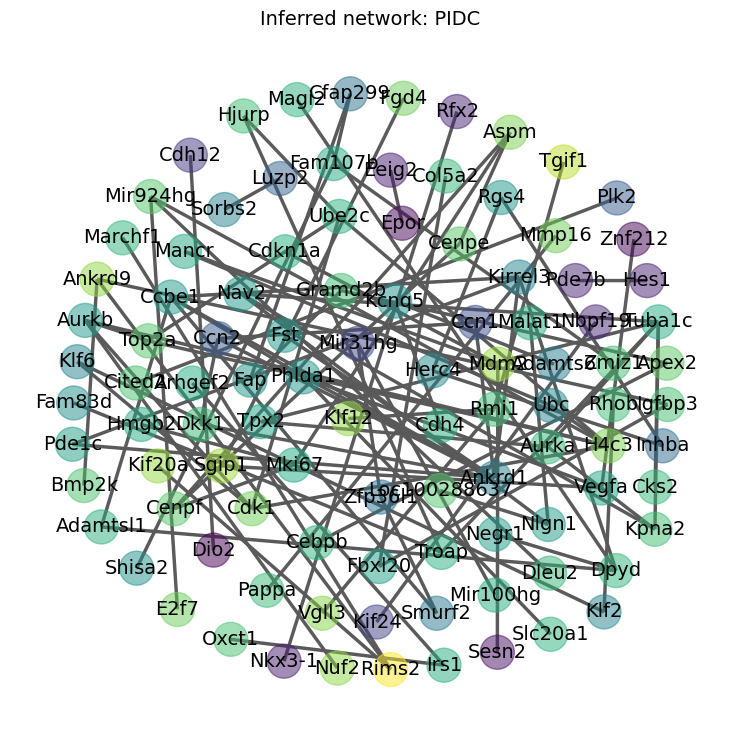

In [312]:
# for PIDC
pd.DataFrame(np.array(adata.X), columns = adata.var.gene).T.to_csv("expr.csv")
A_pidc = np.load("A_pidc.npy");

g = nx.Graph(A_pidc.reshape(adata.shape[1], adata.shape[1]))
nx.set_node_attributes(g, nx.eigenvector_centrality(g, weight = "weight", max_iter = 2_500), "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
plt.figure(figsize = (7.5, 7.5))
visutil.draw(g, adata.var.gene, thresh = 0.995, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"}, layout_args = "-Gstart=0")
plt.axis("off")
plt.title("Inferred network: PIDC", fontsize = 14)
plt.tight_layout()
plt.savefig(FIG_DIR + "cellcycle_pidc.pdf")

In [313]:
adata.shape

(2793, 200)